#### First import necessary libraries

In [175]:
import pandas as pd
import lxml
import folium
from geopy.geocoders import Nominatim
import requests
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

#### Lets scrape st louis neighborhood race data

In [176]:
url = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_of_St._Louis'
stl = pd.read_html(url, header=0)[1]
stl

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South
...,...,...,...,...,...,...,...,...,...
74,Walnut Park East,4130,1.5,96.7,0.8,0.10,0.0,1.5,North
75,Walnut Park West,3349,1.1,97.9,0.8,0.00,0.0,0.8,North
76,Wells/Goodfellow,5859,0.7,97.5,0.6,0.20,0.2,1.4,North
77,West End,6574,8.1,84.9,3.8,0.20,1.5,2.5,North


####  Add latitude and longitude using geopy library

In [177]:
stl['Latitude'] = np.nan
stl['Longitude'] = np.nan

for i in range(len(stl)):
    address = '{}, Saint Louis, MO'.format(stl['Neighborhood'][i])
    print(address)
    geolocator = Nominatim(user_agent="stl_explorer")
    location = geolocator.geocode(address)
    if location is not None:
        stl['Latitude'][i] = location.latitude
        stl['Longitude'][i] = location.longitude
stl.head()

Academy, Saint Louis, MO


/opt/anaconda3/envs/myml/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/myml/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Baden, Saint Louis, MO
Benton Park, Saint Louis, MO
Benton Park West, Saint Louis, MO
Bevo Mill, Saint Louis, MO
Botanical Heights, Saint Louis, MO
Boulevard Heights, Saint Louis, MO
Carondelet, Saint Louis, MO
Carr Square, Saint Louis, MO
Central West End, Saint Louis, MO
Cheltenham, Saint Louis, MO
Clayton-Tamm, Saint Louis, MO
Clifton Heights, Saint Louis, MO
College Hill, Saint Louis, MO
Columbus Square, Saint Louis, MO
Compton Heights, Saint Louis, MO
DeBaliviere Place, Saint Louis, MO
Downtown, Saint Louis, MO
Downtown West, Saint Louis, MO
Dutchtown, Saint Louis, MO
Ellendale, Saint Louis, MO
Fairground, Saint Louis, MO
Forest Park Southeast, Saint Louis, MO
Fountain Park, Saint Louis, MO
Fox Park, Saint Louis, MO
Franz Park, Saint Louis, MO
The Gate District, Saint Louis, MO
Grand Center, Saint Louis, MO
Gravois Park, Saint Louis, MO
Greater Ville, Saint Louis, MO
Hamilton Heights, Saint Louis, MO
The Hill, Saint Louis, MO
Hi-Pointe, Saint Louis, MO
Holly Hills, Saint Louis, MO

,Neighborhood,Population,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,Corridor,Latitude,Longitude
0,Academy,3006,16.9,54.7,20.5,1.52,4.3,3.5,North,38.658421,-90.267226
1,Baden,7268,6.3,91.8,0.5,0.10,0.0,1.3,North,38.709732,-90.230830
2,Benton Park,3532,68.2,25.1,3.2,0.30,1.2,3.8,South,38.598678,-90.219755
3,Benton Park West,4404,28.0,59.6,10.5,0.00,1.9,5.1,South,38.597977,-90.230015
4,Bevo Mill,12654,74.2,13.8,7.5,0.40,4.6,3.9,South,38.581346,-90.267165


#### Drop rows where data is not available

In [178]:
stl.dropna(inplace=True)
stl.shape

(78, 11)

#### Create map

In [179]:
address = 'Saint Louis, MO'
geolocator = Nominatim(user_agent="stl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [180]:
map_stl = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, neighborhood in zip(stl['Latitude'], stl['Longitude'], stl['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_stl)  
    
map_stl

#### Cluster neighborhoods based on demography

In [181]:
stl_demo = stl[['Neighborhood', 'White', 'Black', 'Hispanic/Latino2', 'AIAN1', 'Asian', 'Mixed Race']]
# set number of clusters
kclusters = 5

stl_demo_clustering = stl_demo.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(stl_demo_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 1, 3, 2, 3, 2, 4, 0, 1], dtype=int32)

In [182]:
stl_demo.insert(0, 'Cluster Labels', kmeans.labels_)

stl_demo_merged = stl[['Neighborhood', 'Population', 'Corridor', 'Latitude', 'Longitude']]

stl_demo_merged = stl_demo_merged.join(stl_demo.set_index('Neighborhood'), on='Neighborhood')

stl_demo_merged.head()

,Neighborhood,Population,Corridor,Latitude,Longitude,Cluster Labels,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race
0,Academy,3006,North,38.658421,-90.267226,3,16.9,54.7,20.5,1.52,4.3,3.5
1,Baden,7268,North,38.709732,-90.230830,0,6.3,91.8,0.5,0.10,0.0,1.3
2,Benton Park,3532,South,38.598678,-90.219755,1,68.2,25.1,3.2,0.30,1.2,3.8
3,Benton Park West,4404,South,38.597977,-90.230015,3,28.0,59.6,10.5,0.00,1.9,5.1
4,Bevo Mill,12654,South,38.581346,-90.267165,2,74.2,13.8,7.5,0.40,4.6,3.9


#### Lets visualize the demography clusters

In [183]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stl_demo_merged['Latitude'], stl_demo_merged['Longitude'], stl_demo_merged['Neighborhood'], stl_demo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Check corridors in each cluster

In [184]:
stl_grp_corridor = stl_demo_merged.groupby(["Cluster Labels", "Corridor"]).size().reset_index().rename(columns={0:"count"})

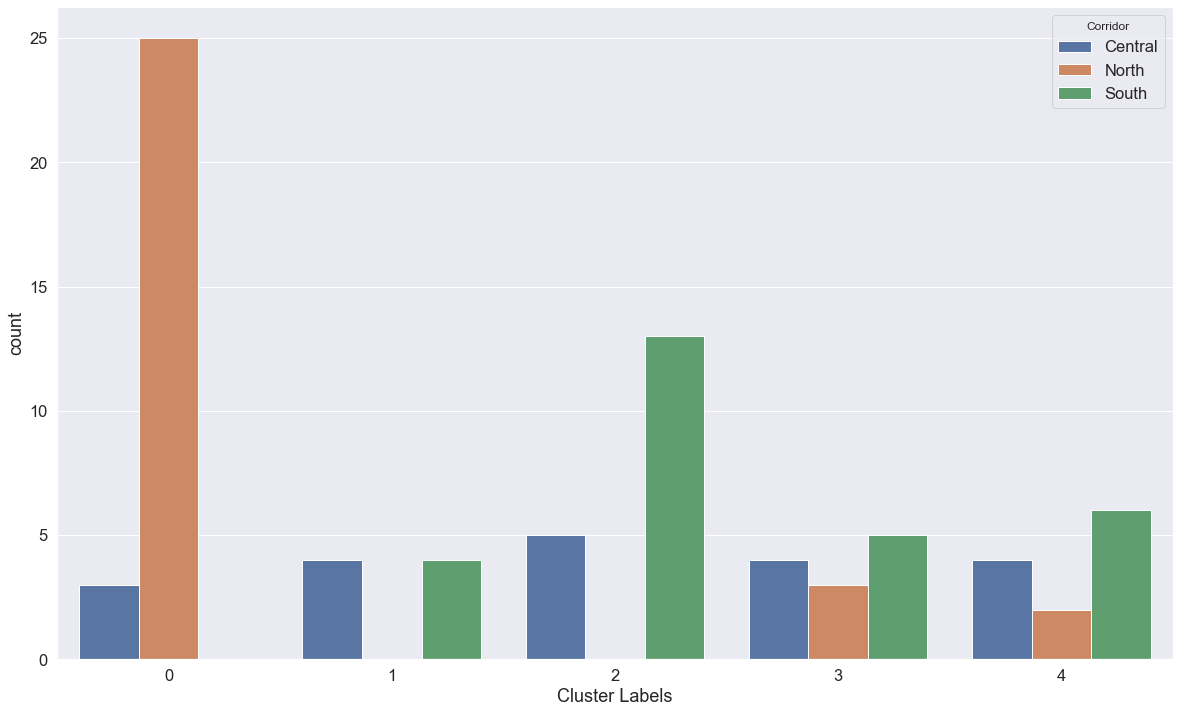

In [185]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.5)
sns.barplot(x="Cluster Labels", y="count", hue="Corridor", data=stl_grp_corridor)
plt.show()

Cluster 0 covers predominatly Northern nrighborhood while Cluster 2 covers Southern. What is different about these neighborhood clusters? Lets check cluster 0.

In [186]:
stl_demo_merged[stl_demo_merged['Cluster Labels'] == 0]

,Neighborhood,Population,Corridor,Latitude,Longitude,Cluster Labels,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race
1,Baden,7268,North,38.709732,-90.230830,0,6.3,91.8,0.5,0.1,0.0,1.3
8,Carr Square,2774,North,38.639669,-90.202702,0,0.5,98.0,0.5,0.3,0.0,0.9
13,College Hill,1870,North,38.672545,-90.209185,0,3.7,92.7,1.2,0.5,0.6,2.3
14,Columbus Square,1869,North,38.637186,-90.190310,0,4.1,92.9,0.9,0.2,0.6,1.9
21,Fairground,1793,North,38.666933,-90.213031,0,1.7,97.1,0.5,0.1,0.0,1.0
23,Fountain Park,1484,North,38.656373,-90.259583,0,1.2,84.4,8.5,0.0,0.0,4.3
26,The Gate District,3546,Central,38.619519,-90.229346,0,14.4,82.0,1.1,0.2,1.3,1.4
29,Greater Ville,6189,North,38.664489,-90.236048,0,0.7,97.4,0.7,0.2,0.0,1.4
30,Hamilton Heights,3105,North,38.668238,-90.279193,0,1.0,97.4,0.5,0.3,0.1,1.2
34,Hyde Park,2668,North,38.660239,-90.203322,0,13.6,84.8,0.9,0.0,0.0,1.3


#### Cluster 0 appears to be predominantly Black. Lets check average distribution of demogrpahy in each cluster.

In [187]:
stl_demo_merged.groupby(['Cluster Labels'])['White', 'Black', 'Hispanic/Latino2', 'AIAN1', 'Asian', 'Mixed Race'].mean()

/opt/anaconda3/envs/myml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race
Cluster Labels,,,,,,
0,3.989286,93.289286,1.182143,0.189286,0.282143,1.607143
1,63.950000,24.437500,3.587500,0.287500,6.712500,3.412500
2,85.266667,8.350000,3.744444,0.244444,2.616667,2.338889
3,27.475000,62.791667,6.825000,0.318333,2.450000,2.608333
4,49.000000,42.625000,3.516667,0.325000,2.925000,3.666667


It appears that cluster 0 neighborhoods are predominantly Black (average population 93.29%) while cluster 1 neighborhoods are predominantly White (average population 85.27%).

#### Let's explore venues in predominantly Black neighborhood

In [188]:
stl_wht = stl_demo_merged[stl_demo_merged['Cluster Labels'] == 0]
stl_blk["Population"].sum()

93648

#### Get venues in Black neighborbooh using Foursquare API

In [189]:
CLIENT_ID = 'UJ50WNYHVNFA5K1TC34PUAMWMXLE425WQE2TT1DZ1PNRVT1Y' # your Foursquare ID
CLIENT_SECRET = 'DTHVZJJ4GTTX2WRPUMFLH4BS0YRDGIRU5MFV22L5OKXOJ2N2' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [190]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [191]:
stl_blk_venues = getNearbyVenues(names=stl_blk['Neighborhood'],
                                   latitudes=stl_blk['Latitude'],
                                   longitudes=stl_blk['Longitude']
                                  )

Baden
Carr Square
College Hill
Columbus Square
Fairground
Fountain Park
The Gate District
Greater Ville
Hamilton Heights
Hyde Park
Kingsway East
Kingsway West
Lewis Place
Mark Twain
Mark Twain/I-70 Industrial
North Point
O’Fallon
Peabody Darst Webbe
Penrose
St. Louis Place
Tiffany
Vandeventer
The Ville
Visitation Park
Walnut Park East
Walnut Park West
Wells/Goodfellow
West End


In [192]:
print(stl_blk_venues.shape)
stl_blk_venues.head()

(107, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Baden,38.709732,-90.230830,Dogtown Pizza,38.709519,-90.229814,Pizza Place
1,Baden,38.709732,-90.230830,Yours Market,38.709308,-90.230313,Grocery Store
2,Baden,38.709732,-90.230830,Under My Feet,38.711667,-90.230579,Shoe Store
3,Baden,38.709732,-90.230830,Vinh Chop Suey,38.712732,-90.229956,Asian Restaurant
4,Carr Square,38.639669,-90.202702,Murphy Park,38.643040,-90.203781,Park


In [193]:
stl_blk_venues.groupby('Neighborhood', as_index=False)["Venue Category"].count().sort_values("Venue Category", ascending=False)

,Neighborhood,Venue Category
16,Peabody Darst Webbe,15
21,Tiffany,9
5,Fountain Park,7
15,O’Fallon,5
22,Vandeventer,5
7,Hamilton Heights,5
23,Visitation Park,5
0,Baden,4
19,The Gate District,4
18,St. Louis Place,4


Peabody Darst Webbe appears to have the highest number of venues. What's the population there?

In [194]:
stl_blk[stl_blk["Neighborhood"] == "Peabody Darst Webbe"]["Population"]

57    2378
Name: Population, dtype: int64

In [195]:
# one hot encoding
stl_blk_onehot = pd.get_dummies(stl_blk_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stl_blk_onehot['Neighborhood'] = stl_blk_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [stl_blk_onehot.columns[-1]] + list(stl_blk_onehot.columns[:-1])
stl_blk_onehot = stl_blk_onehot[fixed_columns]

stl_blk_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Automotive Shop,BBQ Joint,Bar,Brewery,Cafeteria,Café,Child Care Service,...,Shipping Store,Shoe Store,Southern / Soul Food Restaurant,Supermarket,Theater,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Baden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Baden,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Baden,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Baden,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Carr Square,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
stl_blk_grouped = stl_blk_onehot.groupby('Neighborhood').mean().reset_index()
stl_blk_grouped

,Neighborhood,American Restaurant,Asian Restaurant,Automotive Shop,BBQ Joint,Bar,Brewery,Cafeteria,Café,Child Care Service,...,Shipping Store,Shoe Store,Southern / Soul Food Restaurant,Supermarket,Theater,Video Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Baden,0.000000,0.25,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.25,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,Carr Square,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,College Hill,0.000000,0.00,0.0,0.0,0.250000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,Columbus Square,0.000000,0.00,0.0,0.0,0.333333,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,Fairground,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,Fountain Park,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
6,Greater Ville,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
7,Hamilton Heights,0.400000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
8,Hyde Park,0.333333,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,Kingsway East,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.000000,...,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000


#### Get 5 most common venues in Black neighborhoods

In [197]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [198]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = stl_blk_grouped['Neighborhood']

for ind in np.arange(stl_blk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stl_blk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baden,Pizza Place,Asian Restaurant,Grocery Store,Shoe Store,Cosmetics Shop
1,Carr Square,Park,Yoga Studio,History Museum,Gym,Grocery Store
2,College Hill,Bar,Fried Chicken Joint,Nightclub,Discount Store,Yoga Studio
3,Columbus Square,Pizza Place,Bar,Dive Bar,Cosmetics Shop,Gym
4,Fairground,Food,Chinese Restaurant,Discount Store,Convenience Store,Yoga Studio


In [199]:
stl_blk_merged = stl_blk.merge(neighborhoods_venues_sorted, on="Neighborhood", how="left")
stl_blk_merged.head()

,Neighborhood,Population,Corridor,Latitude,Longitude,Cluster Labels,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Baden,7268,North,38.709732,-90.230830,0,6.3,91.8,0.5,0.1,0.0,1.3,Pizza Place,Asian Restaurant,Grocery Store,Shoe Store,Cosmetics Shop
1,Carr Square,2774,North,38.639669,-90.202702,0,0.5,98.0,0.5,0.3,0.0,0.9,Park,Yoga Studio,History Museum,Gym,Grocery Store
2,College Hill,1870,North,38.672545,-90.209185,0,3.7,92.7,1.2,0.5,0.6,2.3,Bar,Fried Chicken Joint,Nightclub,Discount Store,Yoga Studio
3,Columbus Square,1869,North,38.637186,-90.190310,0,4.1,92.9,0.9,0.2,0.6,1.9,Pizza Place,Bar,Dive Bar,Cosmetics Shop,Gym
4,Fairground,1793,North,38.666933,-90.213031,0,1.7,97.1,0.5,0.1,0.0,1.0,Food,Chinese Restaurant,Discount Store,Convenience Store,Yoga Studio


#### Lets look at the most common venues in Black neighborhoods

In [200]:
stl_blk_merged.groupby(["1st Most Common Venue"]).size().reset_index().rename(columns={0:"count"}).sort_values("count", ascending=False)

,1st Most Common Venue,count
10,Park,4
0,American Restaurant,3
2,Bar,3
5,Discount Store,2
12,Pizza Place,2
8,Gym,2
4,Convenience Store,2
6,Food,1
7,Gas Station,1
1,BBQ Joint,1


It turns out that Park is the most common venues among the Black neighborhoods.

#### Now, lets check what's the most common venue among White neighboorhoods

In [201]:
stl_wht = stl_demo_merged[stl_demo_merged['Cluster Labels'] == 2]

In [202]:
stl_wht["Population"].sum()

89775

In [203]:
stl_wht_venues = getNearbyVenues(names=stl_wht['Neighborhood'],
                                   latitudes=stl_wht['Latitude'],
                                   longitudes=stl_wht['Longitude']
                                  )

Bevo Mill
Boulevard Heights
Clayton-Tamm
Clifton Heights
Ellendale
Franz Park
The Hill
Hi-Pointe
Holly Hills
Lafayette Square
Lindenwood Park
North Hampton
Princeton Heights
Soulard
South Hampton
Southwest Garden
St. Louis Hills
Wydown/Skinker


In [204]:
print(stl_wht_venues.shape)
stl_wht_venues.head()

(258, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bevo Mill,38.581346,-90.267165,Silver Ballroom,38.583277,-90.266793,Arcade
1,Bevo Mill,38.581346,-90.267165,Mariachi's II,38.583474,-90.264795,Mexican Restaurant
2,Bevo Mill,38.581346,-90.267165,The Heavy Anchor,38.579531,-90.269173,Bar
3,Bevo Mill,38.581346,-90.267165,Taco Circus,38.578102,-90.268369,Taco Place
4,Bevo Mill,38.581346,-90.267165,Pepper's,38.578114,-90.271039,Bar


Interesting. So there are more venues (255) in White neighborboods than Black (105). It could just mean Foursquare usage distribution.

In [205]:
stl_wht_venues.groupby('Neighborhood', as_index=False)["Venue Category"].count().sort_values("Venue Category", ascending=False)

,Neighborhood,Venue Category
13,South Hampton,37
16,The Hill,30
4,Ellendale,28
8,Lafayette Square,25
12,Soulard,23
2,Clayton-Tamm,19
6,Hi-Pointe,16
0,Bevo Mill,13
14,Southwest Garden,11
7,Holly Hills,10


In [206]:
# one hot encoding
stl_wht_onehot = pd.get_dummies(stl_wht_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
stl_wht_onehot['Neighborhood'] = stl_wht_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [stl_wht_onehot.columns[-1]] + list(stl_wht_onehot.columns[:-1])
stl_wht_onehot = stl_wht_onehot[fixed_columns]

stl_wht_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,...,Tapas Restaurant,Tex-Mex Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Bevo Mill,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Bevo Mill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bevo Mill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bevo Mill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bevo Mill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [207]:
stl_wht_grouped = stl_wht_onehot.groupby('Neighborhood').mean().reset_index()
stl_wht_grouped

,Neighborhood,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Auto Dealership,Automotive Shop,BBQ Joint,...,Tapas Restaurant,Tex-Mex Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Bevo Mill,0.000000,0.000000,0.076923,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
1,Boulevard Heights,0.000000,0.000000,0.000000,0.000000,0.125,0.000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125,0.00
2,Clayton-Tamm,0.000000,0.052632,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.052632,...,0.000000,0.0,0.000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000,0.00
3,Clifton Heights,0.000000,0.200000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.200000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
4,Ellendale,0.035714,0.000000,0.000000,0.000000,0.000,0.000,0.035714,0.000000,0.035714,...,0.000000,0.0,0.000,0.000000,0.035714,0.000000,0.000000,0.000000,0.000,0.00
5,Franz Park,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.2,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
6,Hi-Pointe,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
7,Holly Hills,0.000000,0.200000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00
8,Lafayette Square,0.000000,0.080000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000,0.04
9,Lindenwood Park,0.000000,0.000000,0.000000,0.000000,0.000,0.125,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00


#### Lets get top 5 venues in White neighborhoods and see if Park comes as the first.

In [208]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = stl_wht_grouped['Neighborhood']

for ind in np.arange(stl_wht_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(stl_wht_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bevo Mill,Bar,Mexican Restaurant,Eastern European Restaurant,Market,Bosnian Restaurant
1,Boulevard Heights,Food Truck,Nightclub,Women's Store,Music Store,Arts & Crafts Store
2,Clayton-Tamm,Sandwich Place,Bar,Coffee Shop,Chinese Restaurant,Pizza Place
3,Clifton Heights,Convenience Store,BBQ Joint,Sports Bar,Park,American Restaurant
4,Ellendale,Pizza Place,Sandwich Place,Convenience Store,Accessories Store,Moroccan Restaurant


In [209]:
stl_wht_merged = stl_wht.merge(neighborhoods_venues_sorted, on="Neighborhood", how="left")
stl_wht_merged.head()

,Neighborhood,Population,Corridor,Latitude,Longitude,Cluster Labels,White,Black,Hispanic/Latino2,AIAN1,Asian,Mixed Race,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bevo Mill,12654,South,38.581346,-90.267165,2,74.2,13.8,7.5,0.4,4.6,3.9,Bar,Mexican Restaurant,Eastern European Restaurant,Market,Bosnian Restaurant
1,Boulevard Heights,8708,South,38.560671,-90.278996,2,89.5,3.6,3.5,0.3,3.6,2.0,Food Truck,Nightclub,Women's Store,Music Store,Arts & Crafts Store
2,Clayton-Tamm,2251,Central,38.628147,-90.292964,2,89.0,6.0,2.6,0.2,2.0,2.1,Sandwich Place,Bar,Coffee Shop,Chinese Restaurant,Pizza Place
3,Clifton Heights,3074,South,38.612840,-90.293140,2,90.1,3.9,3.0,0.5,1.9,2.4,Convenience Store,BBQ Joint,Sports Bar,Park,American Restaurant
4,Ellendale,1575,South,38.613108,-90.312337,2,80.6,11.9,7.3,0.4,0.8,3.5,Pizza Place,Sandwich Place,Convenience Store,Accessories Store,Moroccan Restaurant


In [210]:
stl_wht_merged.groupby(["1st Most Common Venue"]).size().reset_index().rename(columns={0:"count"}).sort_values("count", ascending=False)

,1st Most Common Venue,count
0,American Restaurant,2
1,Bar,2
7,Italian Restaurant,2
8,Park,2
9,Pizza Place,2
2,Convenience Store,1
3,Dessert Shop,1
4,Food Truck,1
5,Grocery Store,1
6,Intersection,1


In [211]:
stl_wht_merged.groupby(["2nd Most Common Venue"]).size().reset_index().rename(columns={0:"count"}).sort_values("count", ascending=False)

,2nd Most Common Venue,count
0,BBQ Joint,2
4,Dive Bar,2
14,Sandwich Place,2
1,Bar,1
2,Brewery,1
3,Coffee Shop,1
5,Massage Studio,1
6,Mediterranean Restaurant,1
7,Mexican Restaurant,1
8,Movie Theater,1


In [212]:
stl_wht_merged.groupby(["3rd Most Common Venue"]).size().reset_index().rename(columns={0:"count"}).sort_values("count", ascending=False)

,3rd Most Common Venue,count
3,Coffee Shop,2
4,Convenience Store,2
0,Asian Restaurant,1
1,Bakery,1
2,Brewery,1
5,Eastern European Restaurant,1
6,Greek Restaurant,1
7,Gym / Fitness Center,1
8,Home Service,1
9,Italian Restaurant,1


In [213]:
stl_wht_merged.groupby(["4th Most Common Venue"]).size().reset_index().rename(columns={0:"count"}).sort_values("count", ascending=False)

,4th Most Common Venue,count
12,Park,2
0,Accessories Store,1
9,Lounge,1
15,Tex-Mex Restaurant,1
14,Sandwich Place,1
13,Restaurant,1
11,Music Store,1
10,Market,1
8,Intersection,1
1,Beer Garden,1


It runs out that park is the fourth most common venue among White neighborhoods.